In [26]:
import sys
import os

sys.path.append(r"C:\python\HydroGenerate")  # Ensure HydroGenerate is found

# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
# Import Hydrogenerate
from HydroGenerate.hydropower_potential import *
from HydroGenerate.summary_results import *


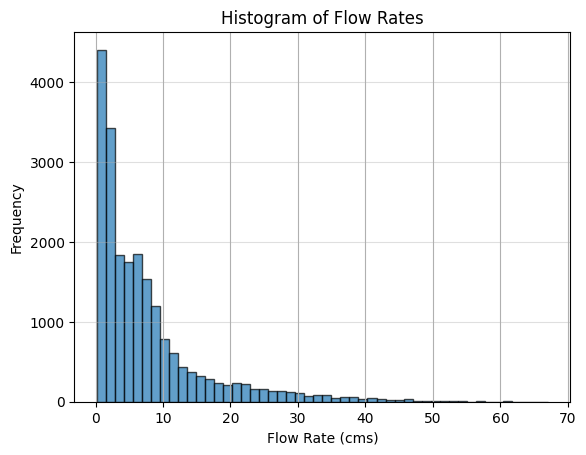

,discharge_cms
count,21186.000000
mean,7.639998
std,8.537493
min,0.213374
25%,1.822106
50%,4.946841
75%,9.444742
max,67.042060


In [27]:
# 2) Using flow as a pandas dataframe and adding annual energy calculation

# Note: When using a pandas dataframe as flow data, please set the datetime index before 
# using HydroGenerate.  (https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html)
data_path = r"GA-19.07_Nupa_rennslisradir_vatnaskil_Q.csv"
flow = pd.read_csv(data_path,sep=";",decimal=".") # pandas data frame
flow['dateTime'] = pd.to_datetime(flow['dateTime'], format="%d.%m.%Y %H:%M", dayfirst=True)

flow = flow.set_index('dateTime') # set datetime index # flolw is in cfs


# Plot histogram
flow['discharge_cms'].hist(bins=50, edgecolor='black', alpha=0.7)

# Formatting
plt.xlabel("Flow Rate (cms)")
plt.ylabel("Frequency")
plt.title("Histogram of Flow Rates")
plt.grid(axis='y', alpha=0.4)

# Show plot
plt.show()
flow.describe()

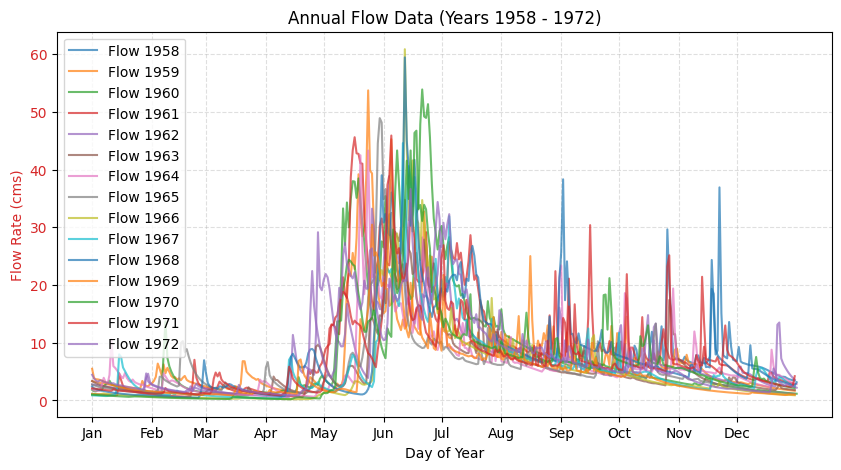

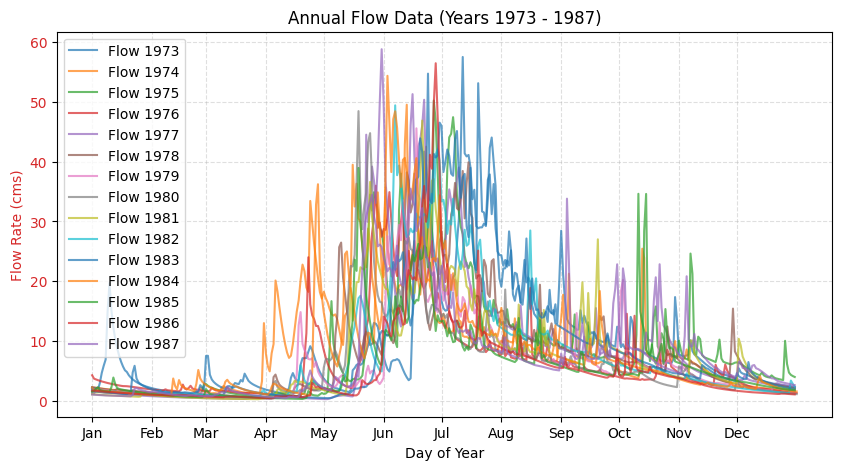

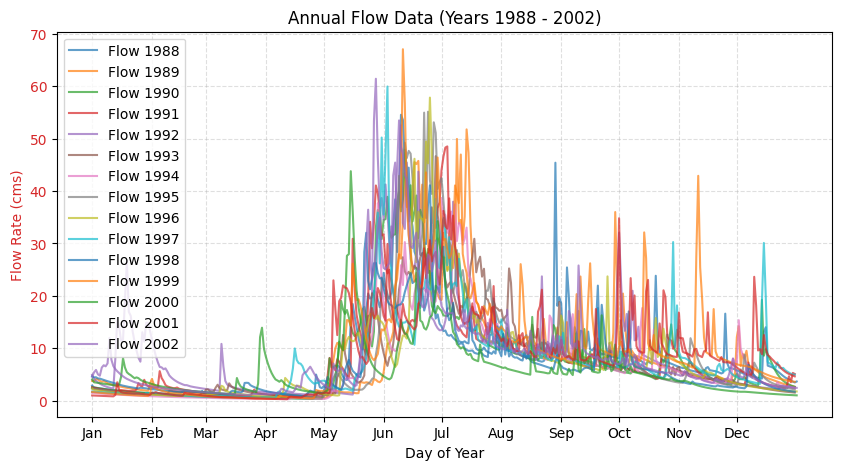

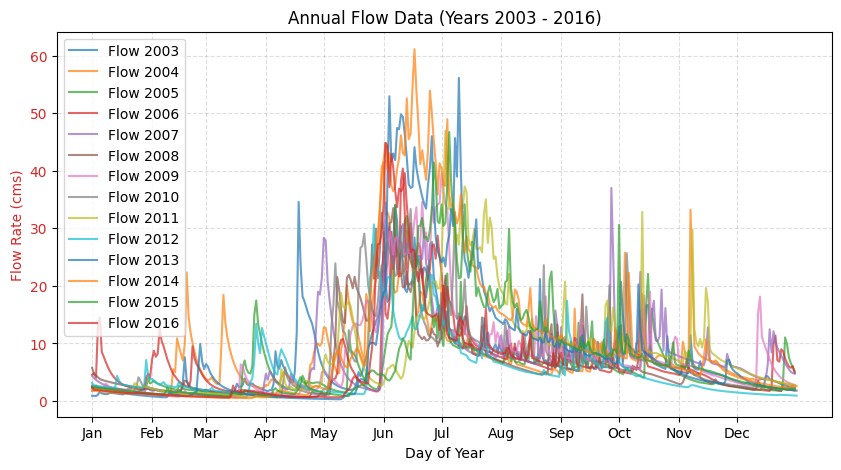

In [28]:

# Ensure datetime index
df = flow.copy()
df.index = pd.to_datetime(df.index)  # Convert index to datetime if not already

# Define the calendar year
df['Year'] = df.index.year

# Normalize dates within the calendar year
df['Day_of_Year'] = df.index.dayofyear

# Get unique years
unique_years = df['Year'].unique()
num_years = len(unique_years)

# Define chunk size (10 years per window to avoid clutter)
chunk_size = 15
num_chunks = (num_years // chunk_size) + 1 if num_years % chunk_size != 0 else (num_years // chunk_size)

# Loop through chunks of 10 years
for chunk in range(num_chunks):
    start_idx = chunk * chunk_size
    end_idx = start_idx + chunk_size
    selected_years = unique_years[start_idx:end_idx]
    
    # Create new figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot each year's flow data separately
    for year in selected_years:
        group = df[df['Year'] == year]
        ax.plot(group['Day_of_Year'], group['discharge_cms'], label=f'Flow {year}', alpha=0.7)

    # Labels & Formatting
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('Flow Rate (cms)', color='tab:red')
    ax.tick_params(axis='y', labelcolor='tab:red')
    ax.grid(True, linestyle='--', alpha=0.4)

    # Format x-axis to show months instead of days
    ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    # Add a single legend
    ax.legend(loc='upper left')

    plt.title(f"Annual Flow Data (Years {selected_years[0]} - {selected_years[-1]})")
    plt.show()


In [29]:

head = 120 # m
power = None
penstock_length = 5200 # m
hp_type = 'Diversion' 
pctime_runfull = 43 # Percent of time a plant runs full. Visit: https://idaholabresearch.github.io/HydroGenerate/Theory_2_Design_Flow.html 
# For more information about design flow calculation
# The following parameters can be included in the computation. Options are commented out when 
# calling calcualte_hp_potential

# a) The type of turbine used in the computation
turbine_type = 'Francis' # Options are 'Pelton', 'Francis', 'Kaplan', 'Crossflow', 'Turbine' and 'Propeller'

# c) The headloss computation method can be changed. Darcy-Weisbach is the default method.
headloss_method= "Hazen-Williams"
C = 150 # Hazen_williamns C

minimum_turbineflow_percent = 25 # percent of design flow that can pass through the turbine



hp = calculate_hp_potential(flow= flow, rated_power= power, head= head,
                            units= "SI",
                            # turbine_type= turbine_type,
                            # pctime_runfull = pctime_runfull,
                            minimum_turbineflow_percent = minimum_turbineflow_percent,

                            penstock_headloss_calculation= True,
                            design_flow= None,
                            electricity_sell_price = 7,
                            hydropower_type= hp_type, penstock_length= penstock_length,
                            penstock_headloss_method= headloss_method, penstock_frictionfactor= C,
                            max_headloss_allowed= 5,
                            flow_column= 'discharge_cms', annual_caclulation= True)

pd.set_option('display.max_columns', 10) # 
pd.set_option('display.width', 1000)

# Explore output
print('Design flow (cms):', hp.design_flow)
print('Penstock length (m):', hp.penstock_length)
print('Head Loss method:',hp.penstock_headloss_method)
print('Penstock diameter (m):', round(hp.penstock_diameter,2))
print('Head_loss at design flow (m):', round(hp.penstock_design_headloss, 2))
print('Net head (m):', round(hp.net_head, 2))
print('Turbine type:', hp.turbine_type)
print('Rated Power (Kw):', round(hp.rated_power, 2))
print('Runner diameter (m):', round(hp.runner_diameter,2))
print('Generator Efficiency:',hp.generator_efficiency)

print('\nResource Category:', hp.resource_category)
print('Initial Capital Cost (M$):', np.round(hp.icc,1))
print('Annual Operation and Maintennance (M$):', np.round(hp.annual_om,1))

print('\nPandas dataframe output: \n', hp.dataframe_output.head())
print('Annual output: \n', hp.annual_dataframe_output.head())




Design flow (cms): 8.473838999999996
Penstock length (m): 5200
Head Loss method: Hazen-Williams
Penstock diameter (m): 2.19
Head_loss at design flow (m): 6.0
Net head (m): 114.0
Turbine type: Francis
Rated Power (Kw): 8646.28
Runner diameter (m): 1.26
Generator Efficiency: 0.98

Resource Category: NEWSTREAM-REACH
Initial Capital Cost (M$): 37.5
Annual Operation and Maintennance (M$): 0.7

Pandas dataframe output: 
             discharge_cms     power_kW  turbine_flow_cfs  efficiency     energy_kWh
dateTime                                                                           
1958-09-01       6.990560  7223.105883          6.990560    0.928139            NaN
1958-09-02       6.863491  7111.013965          6.863491    0.929526  170664.335155
1958-09-03       7.693990  7828.597757          7.693990    0.920462  187886.346163
1958-09-04       6.727033  6989.603519          6.727033    0.930999  167750.484458
1958-09-05       6.619058  6884.194628          6.619058    0.930990  165220.

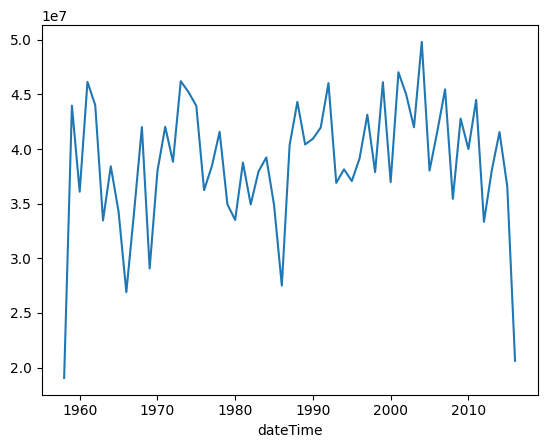

,annual_turbinedvolume_ft3,mean_annual_effienciency,total_annual_energy_KWh,revenue_M$,capacity_factor
count,59.000000,59.000000,5.900000e+01,59.000000,59.000000
mean,1633.936894,0.616303,3.883116e+07,271.818097,0.512681
std,248.973049,0.077894,5.993515e+06,41.954605,0.079131
min,783.208397,0.414156,1.904666e+07,133.326635,0.251470
25%,1541.327259,0.573777,3.616664e+07,253.166470,0.477501
50%,1638.748087,0.615426,3.883674e+07,271.857210,0.512754
75%,1792.782028,0.649091,4.296277e+07,300.739411,0.567230
max,2083.413449,0.913738,4.980875e+07,348.661230,0.657616


In [30]:
hp.annual_dataframe_output["total_annual_energy_KWh"].plot()
plt.show()
hp.annual_dataframe_output.describe()

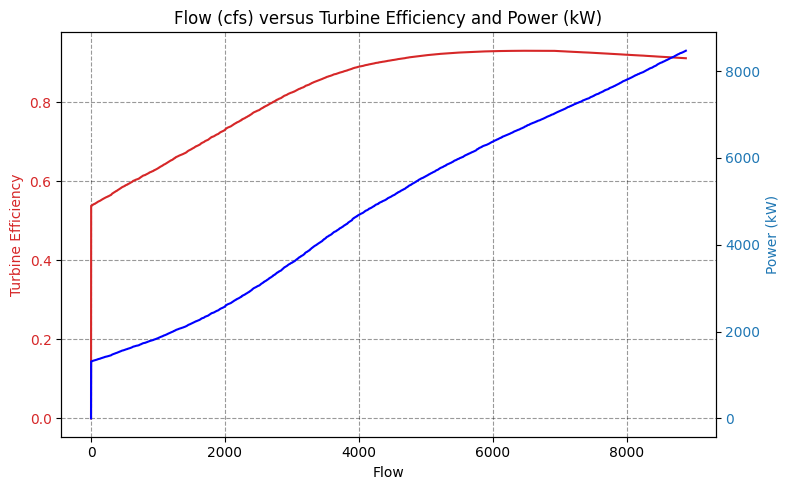

In [31]:
# Turbine efficiency and power as a function of flow
sys.path.append('/c:/python/HydroGenerate/HydroGenerate')
flow_efficiency_power_plot(hp)


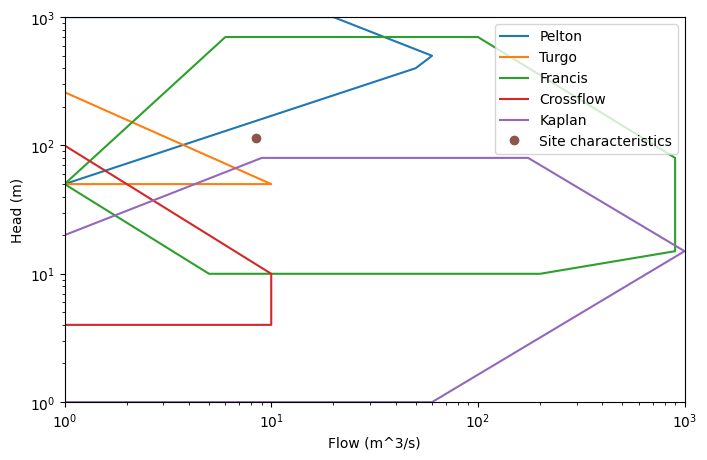

In [32]:
turbine_type_plot(hp)

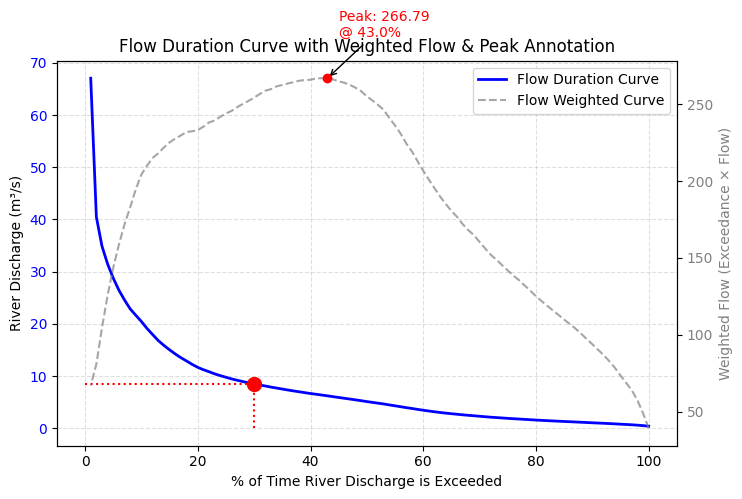

In [33]:
flow_duration_curve_plot(hp)

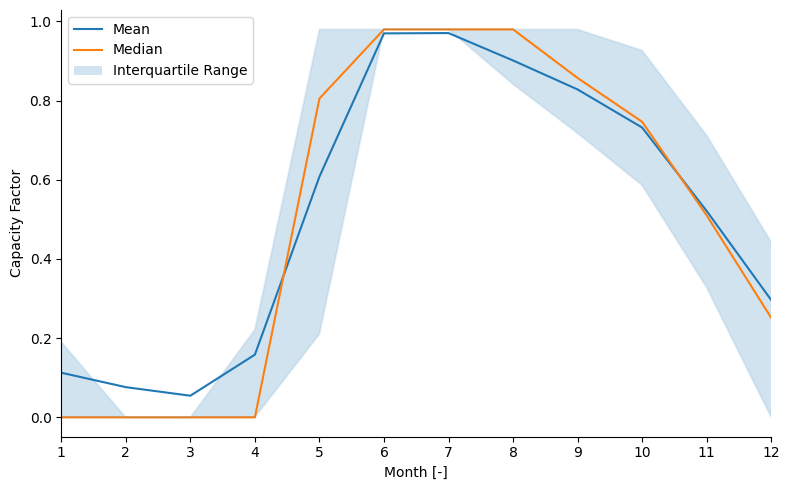

In [34]:
plant_capfactor_plot(hp)